## Introduction

Name : Ravin Mizia Rayeok

Batch : 17 FTDS TMT

Dataset : Twitter Depression Sentiment. url : (https://www.kaggle.com/datasets/gargmanas/sentimental-analysis-for-tweets)

Deployment : url (https://huggingface.co/spaces/ravinmizia/Sentimen_Twitter_Depression)

Objective : Analyze the data and create a model to predict if a tweet contain tendency of depression or not.


## Import Library

In [1]:
# Primary lib
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.regularizers import l1, l2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split

#  Ignore warnings 
import warnings
warnings.filterwarnings("ignore")

# For Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Input, LSTM, GRU, Dropout
from tensorflow.keras.models import Model, Sequential

# Vectorization and Embedding
from tensorflow.keras.layers import TextVectorization, Embedding

# text edit
import re
import string

#Stopwords
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#lemmatizer 
from nltk.stem import WordNetLemmatizer

# countvectorizer
from sklearn.feature_extraction.text import CountVectorizer

#stopword and wordcloud
from wordcloud import WordCloud, STOPWORDS

# for transfer learning
import tensorflow_hub as hub

#for adding class weight
from sklearn.utils import class_weight

# classification report
from sklearn.metrics import classification_report

import pickle
import json

AttributeError: module 'tensorflow.compat.v2.__internal__' has no attribute 'register_load_context_function'

## Data Loading

In [2]:
# load dataa csv
data = pd.read_csv('sentiment_tweets3.csv')

In [3]:
data.head(2)

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0


In [4]:
# cahnge columns for easier reading
data = data.rename({'label (depression result)': 'label', 'message to examine':'message'}, axis=1)

In [5]:
# examine the labeling 
data['label'].value_counts()

0    8000
1    2314
Name: label, dtype: int64

In [6]:
data.shape

(10314, 3)

## EDA 

### 1. Wordcloud Analysis Preprocessed

In [7]:
# create wordclloud function
def Plot_world(text_cloud):
    
    comment_words = ' '
    stopwords = set(STOPWORDS) 
    
    for val in text_cloud: 

        #each val to string 
        val = str(val) 

        # split
        tokens = val.split() 

        # lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + ' '

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    return wordcloud

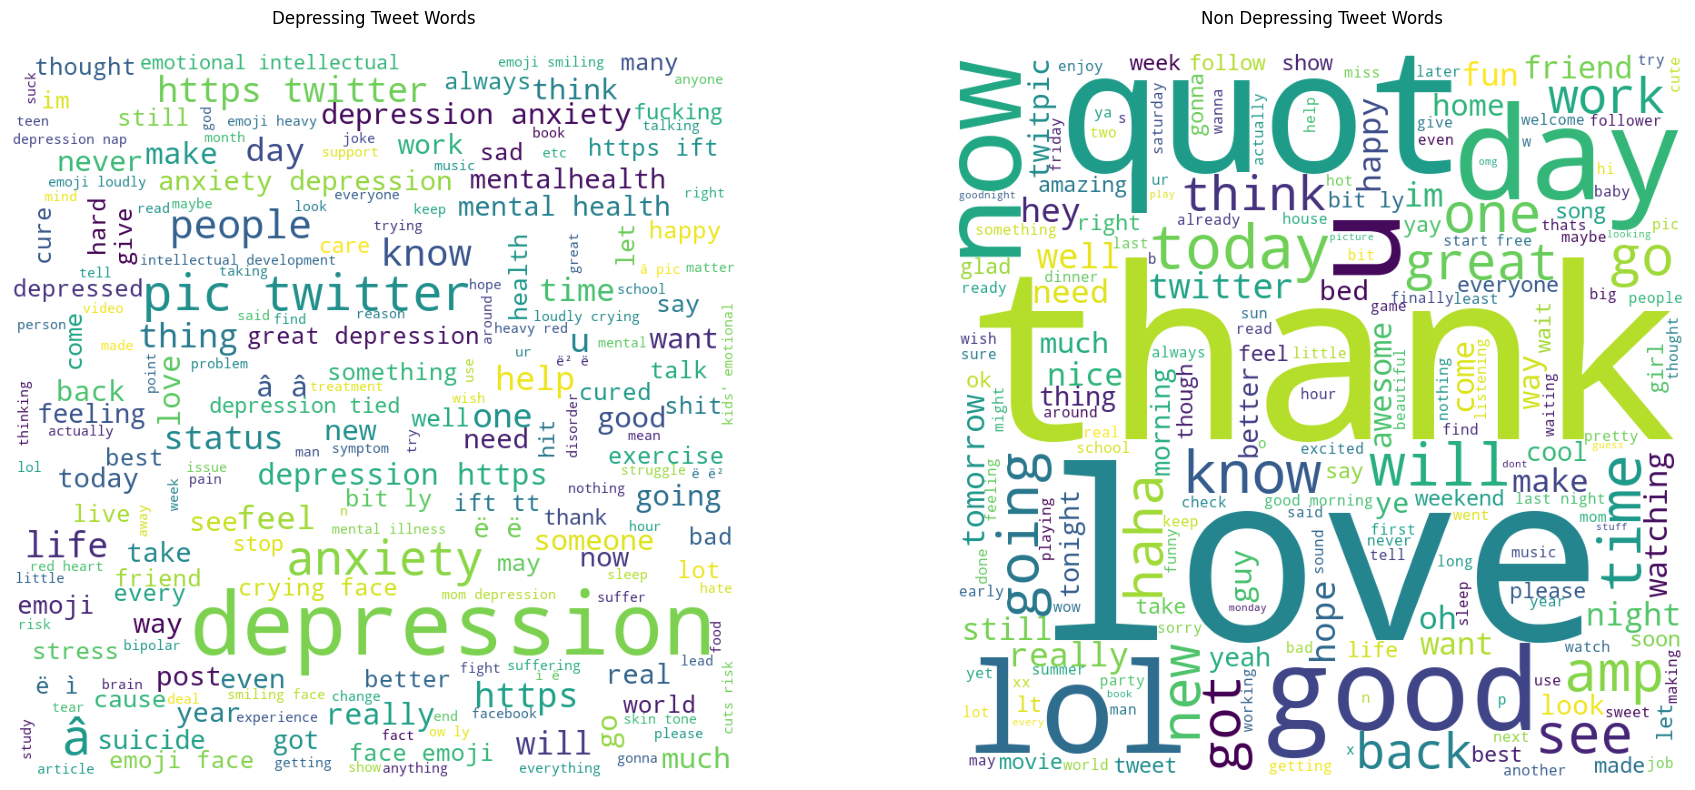

In [8]:
# plotting wordcloud
text_cloud_0 = data[data.label==0].message.values
text_cloud_1 = data[data.label==1].message.values

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,8))

wordcloud_1 = Plot_world(text_cloud_1)
wordcloud_0 = Plot_world(text_cloud_0)

ax1.imshow(wordcloud_1)
ax1.axis('off')
ax1.set_title('Depressing Tweet Words\n')

ax2.imshow(wordcloud_0)
ax2.axis('off')
ax2.set_title('Non Depressing Tweet Words\n')

plt.tight_layout()

We can see from this wordclouds:

1. In depressiong tweet wordcloud, we can clearly see that the word depression is the most tweeted word, followed by anxiety, people, life. It seems like the depressed tweet is having lots of emotion and action here, such as: crying, anxiety, suicide, help, etc.

2. While on the other side, in non depressing tweet wordcloud, we see love and thank is the most mentioned word and also thank and quot. These tweets with no depression tendency indicates hope and gratitude.

Note that the words used to build wordcloud not yet processed that's why there are still some symbols and unnecessary meaningless words. will be examined further after preprocessing

### 2. Tweet Proportion

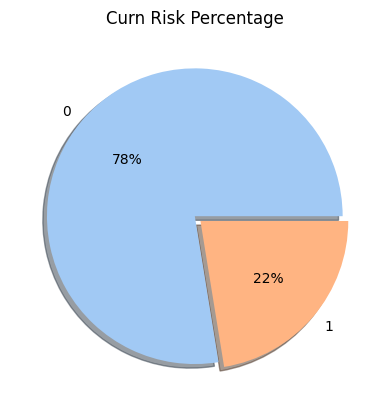

In [9]:
# plotting data on chart
plt.pie(data=data ,x=data.label.value_counts(),labels=data.label.unique(), autopct='%.0f%%', explode = [0, 0.05], shadow=True, colors=sns.color_palette('pastel'))
plt.title('Curn Risk Percentage')
plt.show()

In the pie chart above, 0 means non depression tweet and 1 stands for depressing tweet.

We can see that the data is imbalanced. Tweet with little to no depressed tendency is occupying 78% of the datawhile depressed tweet has 22% only.

In real world case, this proportion is generally acceptable and normal. Why? Because it is not easy to label a tweet to have depressing tendency. Because depression is actually very contextual and personal subject and to analyze and predict them we will need advanced model.

## Check Null Vales

In [10]:
# check null values
data.isnull().sum()

Index      0
message    0
label      0
dtype: int64

There are no null values for each column in dataset

## Preprocessing

In [11]:
# checking
teks = data.message[0]
teks

'just had a real good moment. i missssssssss him so much, '

We filter stopwords sbecause many words are just repeating without any contextual value 

In [12]:
# Stopwords
stpwds_eng = list(set(stopwords.words('english')))
stpwds_eng.append(['oh','s'])

Next is lemmatization, this is a technique to reduce and change the word into their base form. e.g. running to run, feet to foot. etc

lemma is better than stemming, because stemming is just cutting/slincing the letter without giving more attention to the word context.

In [13]:
# lemmatization
nltk.download('wordnet')
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ravin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
data.head(2)

,Index,message,label
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0


In [15]:
#Create Preprocessing Function

def pre_process(text):
 
  text = text.lower() #to lowercase
  
  text = re.sub("@[A-Za-z0-9_]+", " ", text)# Remove Mention
  
  text = re.sub("#[A-Za-z0-9_]+", " ", text)# Remove Hashtag
  
  text = re.sub(r"\\n", " ",text)# Remove \n
 
  text = text.strip() # Remove Whitespace
  
  text = re.sub(r"http\S+", " ", text) # Remove Link
  text = re.sub(r"www.\S+", " ", text)
  
  text = re.sub("[^A-Za-z\s']", " ", text)# Remove symbols, emojis

  tokens = word_tokenize(text)# Tokenization

  text = ' '.join([word for word in tokens if word not in stpwds_eng])# Remove Stopwords
  
  text = lemmatizer.lemmatize(text)# Lemmatizing using WordLemmatizer
  
  return text


In [16]:
# check after and before pre processing
print("after :" ,pre_process(teks))
print("before :" ,teks)

after : real good moment missssssssss much
before : just had a real good moment. i missssssssss him so much, 


In [17]:
# making sure all the data in message is str
data['message'] =  data['message'].astype(str)

In [18]:
# Applying the function of pre processing
data['text_processed'] = data['message'].apply(lambda x: pre_process(x))
data.head(2)

,Index,message,label,text_processed
0,106,just had a real good moment. i missssssssss hi...,0,real good moment missssssssss much
1,217,is reading manga http://plurk.com/p/mzp1e,0,reading manga


In [19]:
#Remove word with 2 letter or less
words_2 = re.compile(r'\W*\b\w{1,2}\b')

data['text_processed']=data['text_processed'].apply(lambda x: words_2.sub('', x) )
data.head()

,Index,message,label,text_processed
0,106,just had a real good moment. i missssssssss hi...,0,real good moment missssssssss much
1,217,is reading manga http://plurk.com/p/mzp1e,0,reading manga
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0,
3,288,@lapcat Need to send 'em to my accountant tomo...,0,need send accountant tomorrow oddly even refer...
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,add myspace myspace com lookthunder


## EDA After Preprocessing

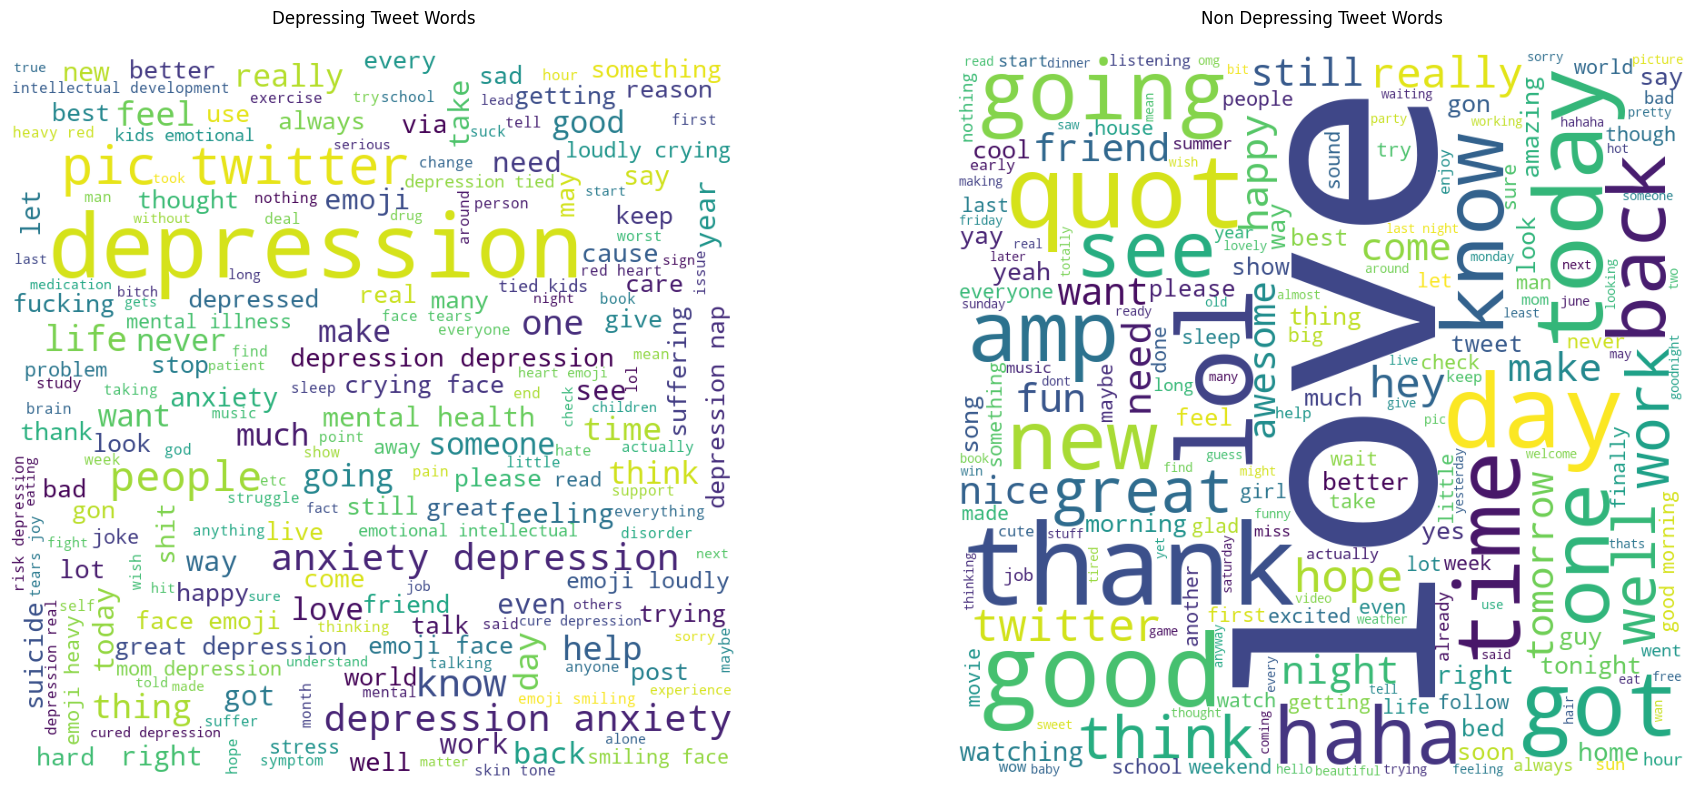

In [22]:
# plotting wordcloud after
text_cloud_0_pr = data[data.label==0].text_processed.values
text_cloud_1_pr = data[data.label==1].text_processed.values

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,8))

wordcloud_1_pr = Plot_world(text_cloud_1_pr)
wordcloud_0_pr = Plot_world(text_cloud_0_pr)

ax1.imshow(wordcloud_1_pr)
ax1.axis('off')
ax1.set_title('Depressing Tweet Words\n')

ax2.imshow(wordcloud_0_pr)
ax2.axis('off')
ax2.set_title('Non Depressing Tweet Words\n')

plt.tight_layout()

Following information can be gathered after preprocessing :

1. From Depressing Tweet: 
    - There's a generally equal distribution of the words comapred to non depressing tweet words, judging them from their size proportion in wordcloud.
    - the word 'depression' is the main star of the tweet, followed by twitter, pic, and anxiety. Now this is interesting, why the word 'twitter' is has the tendency to be depressed? will be further examined

 .

2. From Non_Depressing Tweet:
    - Its very obvious just by seeing teh wordcould that the word "love","thank", and "lol" has the highest rank and showed up more often in the dataset. These words contains the context of feeling relieved and gratitude.


In [27]:
# Find why tweet has such bad notation
twet_dep = data[(data.label==1)&(data['message'].str.contains('twitter'))]
twet_dep_1 =data[(data['message'].str.contains('depression'))&(data['message'].str.contains('twitter'))]

print('amount of tweet with word "twitter" in Depressive Tweet' ,len(twet_dep))
print('amount of tweet with word "twitter" together with word "depression"', len(twet_dep_1))
twet_dep_1


amount of tweet with word "twitter" in Depressive Tweet 433
amount of tweet with word "twitter" together with word "depression" 363


,Index,message,label,text_processed
8005,800005,my anxiety and my depression fighting over who...,1,anxiety depression fighting whos day
8006,800006,wow she's suddenly cured my depression and gav...,1,wow suddenly cured depression gave world peace
8031,800031,Lose your #anger #anxiety #insecurity and #dep...,1,lose via pic twitter com khydrkvj
8044,800044,No one understands how much he has helped me w...,1,one understands much helped seriously never be...
8052,800052,"WIP art of my grandmere, memere, and mom from ...",1,wip art grandmere memere mom back day made ton...
...,...,...,...,...
10272,802272,All the #diet and #exercise #plans aren't #wor...,1,getting fatter enforced pic twitter com rlnggrb
10284,802284,sometimes i don't fit in with my friends and i...,1,sometimes fit friends always verge giving guys...
10295,802295,I love Lauren so much <Emoji: Loudly crying fa...,1,love lauren much emoji loudly crying face emoj...
10305,802305,RT Depression Could Be Improved With Vitamin D...,1,depression could improved vitamin deficiency ...


We can see and examine that some of the depressive tweet that uses the word "twitter" is user who are discussing about depression and some are even doesn't have the context of being depressed.

Again, this depression is very contextual. And this can create a hardship for further modelling.

This indicates in real case or real world, tweet with depression context is actually less than what the data told us.

## Vectoriozing & Tokenizing

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Index           10314 non-null  int64 
 1   message         10314 non-null  object
 2   label           10314 non-null  int64 
 3   text_processed  10314 non-null  object
dtypes: int64(2), object(2)
memory usage: 322.4+ KB


In [24]:
# Splitting Corpus
X_train, X_test, y_train, y_test = train_test_split(data.text_processed, 
                                                    data.label, 
                                                    test_size=0.20, 
                                                    random_state=10, 
                                                    stratify=data.label)

print('Train Size : ', X_train.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (8251,)
Test Size  :  (2063,)


Next step will be vectorizing. We know that the computer doesn't understand words, but it does understand numbers.

In simpler words, vectorization is a technique to convert words into numerical vector to be processed in the model.

We will be using CoutVectorizer to breaking down and vectorized  sentences, texts

In [25]:
# Get Vocabularies
Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<8251x12524 sparse matrix of type '<class 'numpy.int64'>'
	with 61110 stored elements in Compressed Sparse Row format>

In [26]:
# Vocab Lenghth

amt_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print("Vocab Amount : ", amt_vocab)
print("Max Sentence : ", max_sen_len, "words")

Vocab Amount :  12524
Max Sentence :  58 words


In [26]:
# Text Vectorization

text_vectorization = TextVectorization(max_tokens=amt_vocab,
                                       standardize="lower_and_strip_punctuation", # just to be safe
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,) # For Sequential API
                                       )

text_vectorization.adapt(X_train)

In [27]:
# Embedding

embedding = Embedding(input_dim=amt_vocab, # amount wo rds to be embede
                      output_dim=128, 
                      embeddings_initializer="uniform",
                      input_length=max_sen_len
                      )

## ANN (Base)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 58)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 58, 128)           1603072   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,605,153
Trainable params: 1,605,153
Non-

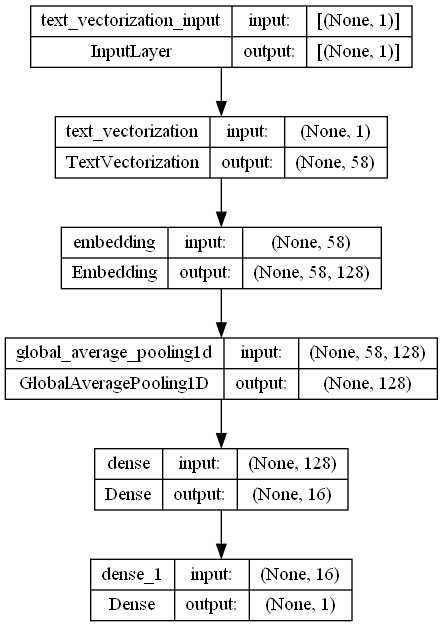

In [88]:
# Model DEfinition
seed = 98
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)


model = Sequential()
model.add(text_vectorization)
model.add(embedding)

model.add(GlobalAveragePooling1D())
model.add(Dense(16,activation='relu'))

model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')

model.summary()
tf.keras.utils.plot_model(model,show_shapes=True)

Applying 

- Two hidden layer namely embedding layer and dense layer with 16 neurons.

- activation relu on dense layer for better performance, and activation sigmoid in output layer becase of binary case.

In [89]:
#model training
model_dnn_hist_1 = model.fit(X_train,
                         y_train,
                         epochs=20,
                         validation_data=(X_test, y_test))

Epoch 1/20
258/258 [==============================] - 5s 16ms/step - loss: 0.3059 - accuracy: 0.8753 - val_loss: 0.1386 - val_accuracy: 0.9743
Epoch 2/20
258/258 [==============================] - 4s 16ms/step - loss: 0.0532 - accuracy: 0.9956 - val_loss: 0.0663 - val_accuracy: 0.9874
Epoch 3/20
258/258 [==============================] - 4s 16ms/step - loss: 0.0201 - accuracy: 0.9976 - val_loss: 0.0524 - val_accuracy: 0.9893
Epoch 4/20
258/258 [==============================] - 4s 16ms/step - loss: 0.0122 - accuracy: 0.9983 - val_loss: 0.0518 - val_accuracy: 0.9884
Epoch 5/20
258/258 [==============================] - 4s 16ms/step - loss: 0.0093 - accuracy: 0.9984 - val_loss: 0.0481 - val_accuracy: 0.9884
Epoch 6/20
258/258 [==============================] - 4s 16ms/step - loss: 0.0079 - accuracy: 0.9987 - val_loss: 0.0482 - val_accuracy: 0.9889
Epoch 7/20
258/258 [==============================] - 4s 16ms/step - loss: 0.0062 - accuracy: 0.9989 - val_loss: 0.0469 - val_accuracy: 0.9889

<AxesSubplot: >

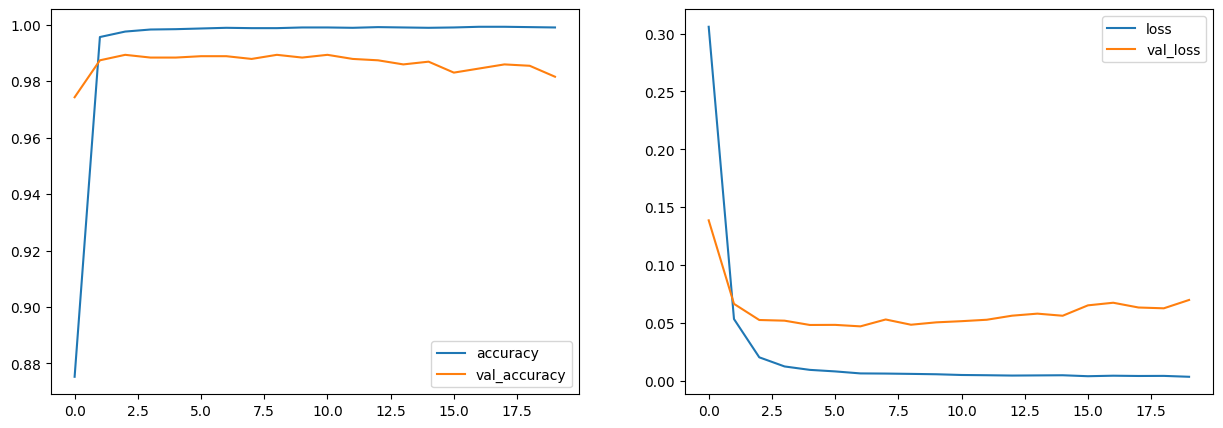

In [90]:
# See Performance
metrics = pd.DataFrame(model_dnn_hist_1.history)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

metrics[['accuracy', 'val_accuracy']].plot(ax=ax1)
metrics[['loss','val_loss']].plot(ax=ax2)

In [91]:
#Classification report

y_pred_ann = model.predict(X_test)
y_pred_ann = np.where(y_pred_ann >= 0.5, 1, 0)


print(classification_report(y_test, y_pred_ann))

65/65 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1600
           1       0.96      0.96      0.96       463

    accuracy                           0.98      2063
   macro avg       0.97      0.97      0.97      2063
weighted avg       0.98      0.98      0.98      2063



`Evaluation`

We can see from the base model, that there is definietly indicaion for overfiitng or underfitting because val_loss line keeps getting worse in each epoch and distance itself from loss in train data. This can be indication caused by data imbalance.

Although the model accuracy is pretty good with ``0.98`` in val_data. 

The sudden spike of accuracy in early iteration (epoch) may indicates that maybe the sample is too small with our model.

## GRU

### BEST GRU 

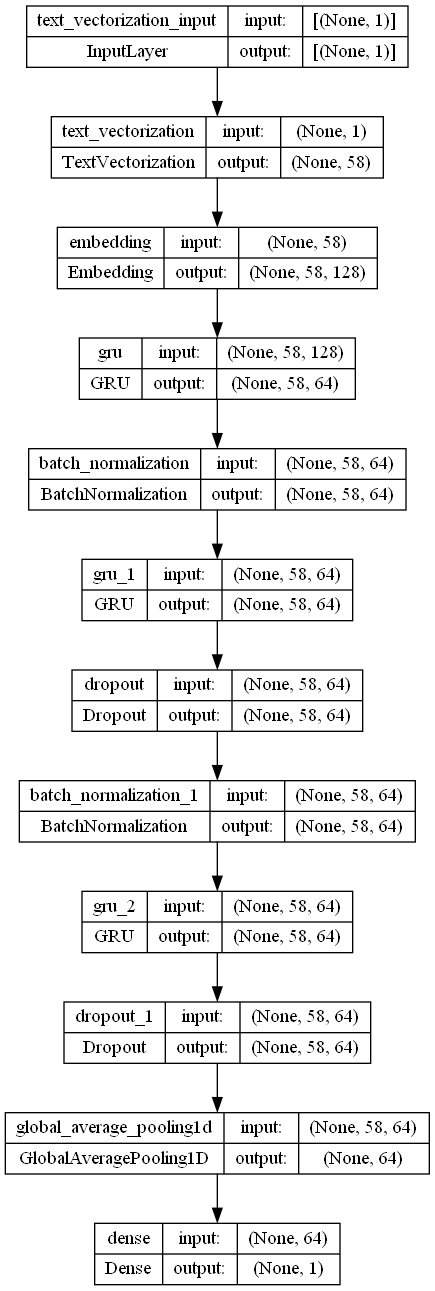

In [84]:
# Using GRU
seed = 11
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)


model_gru = Sequential()
model_gru.add(text_vectorization)
model_gru.add(embedding)


model_gru.add(GRU(64, activation='relu', return_sequences=True))
model_gru.add(tf.keras.layers.BatchNormalization())

model_gru.add(GRU(64, activation='relu',return_sequences=True))
model_gru.add(Dropout(0.5))
model_gru.add(tf.keras.layers.BatchNormalization())


model_gru.add(GRU(64, activation='relu',return_sequences=True))
model_gru.add(Dropout(0.5))

model_gru.add(GlobalAveragePooling1D())

model_gru.add(Dense(1,activation='sigmoid'))

model_gru.compile(loss='binary_crossentropy',optimizer='adam' ,metrics='accuracy')

tf.keras.utils.plot_model(model_gru,show_shapes=True)

Sequential GRU model : 

- Three GRU layers with some other dense layer

- Vectorization layer to input data to numerical vector for futher learning.

- an embedding layer to lower the dimension of input data.

- dropout layer 50% and batchnormalization to normalize output of previous layer.

- activation relu on dense layer for better performance, and activation sigmoid in output layer becase of binary case and optimizer adam.

In [85]:
# train GRU
model_gru_hist = model_gru.fit(X_train,
                         y_train,
                         epochs=20,
                         validation_data=(X_test, y_test))

Epoch 1/20
258/258 [==============================] - 21s 65ms/step - loss: 0.0420 - accuracy: 0.9870 - val_loss: 0.0531 - val_accuracy: 0.9855
Epoch 2/20
258/258 [==============================] - 16s 63ms/step - loss: 0.0081 - accuracy: 0.9984 - val_loss: 0.0827 - val_accuracy: 0.9762
Epoch 3/20
258/258 [==============================] - 16s 63ms/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.0611 - val_accuracy: 0.9898
Epoch 4/20
258/258 [==============================] - 16s 63ms/step - loss: 0.0043 - accuracy: 0.9987 - val_loss: 0.0663 - val_accuracy: 0.9864
Epoch 5/20
258/258 [==============================] - 16s 63ms/step - loss: 0.0046 - accuracy: 0.9982 - val_loss: 0.0792 - val_accuracy: 0.9855
Epoch 6/20
258/258 [==============================] - 16s 63ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.0656 - val_accuracy: 0.9879
Epoch 7/20
258/258 [==============================] - 16s 63ms/step - loss: 0.0033 - accuracy: 0.9989 - val_loss: 0.0816 - val_accuracy:

<AxesSubplot: >

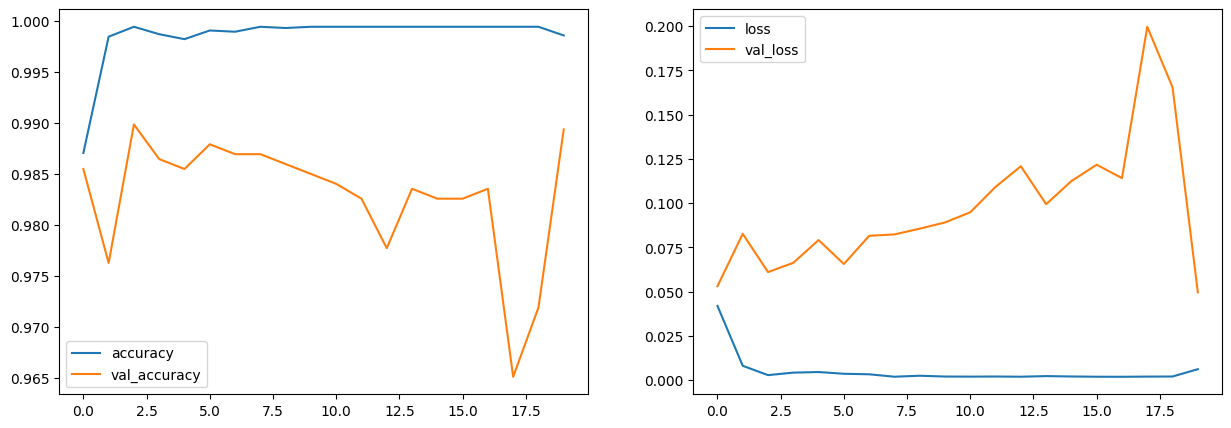

In [86]:
# See Performance

metrics_1 = pd.DataFrame(model_gru_hist.history)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

metrics_1[['accuracy', 'val_accuracy']].plot(ax=ax1)
metrics_1[['loss','val_loss']].plot(ax=ax2)

As we see GRU Modell that has been tried, exposed to poor performance due to high inconsistency in accuracy and loss

In [61]:
#Classification report

y_pred_gru = model_gru.predict(X_test)
y_pred_gru = np.where(y_pred_gru >= 0.5, 1, 0)


print(classification_report(y_test, y_pred_gru))

65/65 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1600
           1       0.98      0.96      0.97       463

    accuracy                           0.99      2063
   macro avg       0.98      0.98      0.98      2063
weighted avg       0.99      0.99      0.99      2063



``Evaluation``

In GRU Model, even though the model has relatively high accuracy for about ``0.98``, we can see many exploding gradient in evaluation dataset both loss metrics. Although it is forgivable for the accuracy metrics because the 'exploding' only happen in small scale, and also we only trained it with 20 epochs. 

In general, exploding gradients makes learning unstable and bad performance for the model. 

This model will not be chosen because baseline model still performs beter.

## LSTM

### BEST LSTM

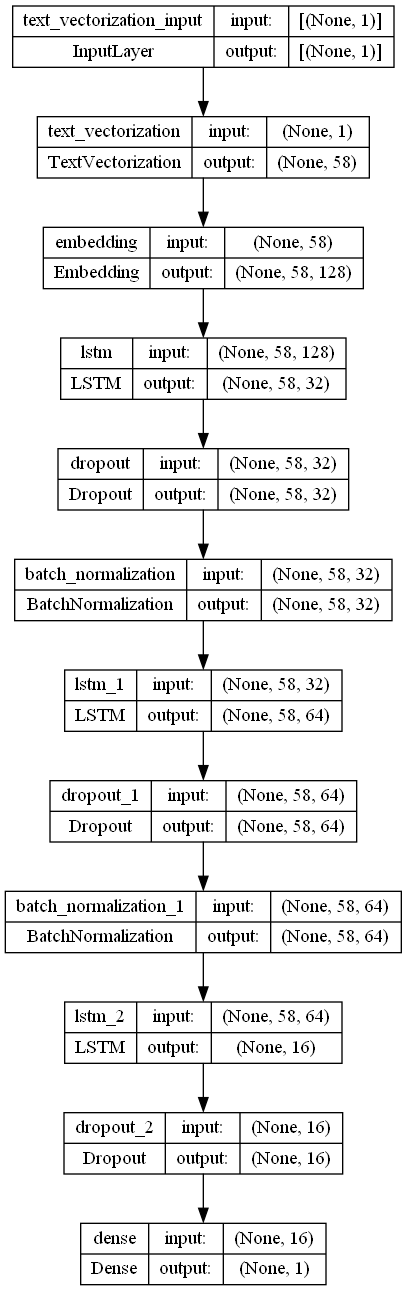

In [62]:
seed = 45
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

model_lstm_3 = Sequential()
model_lstm_3.add(text_vectorization)
model_lstm_3.add(embedding)

model_lstm_3.add(LSTM(32, return_sequences=True, activation='relu'))
model_lstm_3.add(Dropout(0.5))
model_lstm_3.add(tf.keras.layers.BatchNormalization())

model_lstm_3.add(LSTM(64, return_sequences=True, activation='relu'))
model_lstm_3.add(Dropout(0.5))
model_lstm_3.add(tf.keras.layers.BatchNormalization())

model_lstm_3.add(LSTM(16))
model_lstm_3.add(Dropout(0.5))

model_lstm_3.add(Dense(1,activation='sigmoid'))

model_lstm_3.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')

tf.keras.utils.plot_model(model_lstm_3,show_shapes=True)

Sequential LSTM model : 

- Three LSTM layers with some other layers.

- Vectorization layer for input data to numerical vector for futher learning.

- an embedding layer to lower the dimension of input data.

- dropout layer set to 50% for randomly drops 50% value from previous layer, and batchnormalization to normalize output of previous layer.

- activation relu on dense layer for better performance, and activation sigmoid in output layer becase of binary case and optimizer adam.

In [63]:
# Train LSTM
model_lstm_3_hist = model_lstm_3.fit(X_train,
                         y_train, class_weight=class_weight_3,
                         epochs=20,
                         validation_data=(X_test, y_test))

Epoch 1/20
258/258 [==============================] - 17s 53ms/step - loss: 0.3355 - accuracy: 0.9267 - val_loss: 0.6761 - val_accuracy: 0.7843
Epoch 2/20
258/258 [==============================] - 13s 50ms/step - loss: 0.0859 - accuracy: 0.9927 - val_loss: 0.4210 - val_accuracy: 0.8943
Epoch 3/20
258/258 [==============================] - 13s 50ms/step - loss: 0.0631 - accuracy: 0.9933 - val_loss: 0.1342 - val_accuracy: 0.9559
Epoch 4/20
258/258 [==============================] - 13s 50ms/step - loss: 0.0484 - accuracy: 0.9956 - val_loss: 0.1830 - val_accuracy: 0.9559
Epoch 5/20
258/258 [==============================] - 13s 50ms/step - loss: 0.0352 - accuracy: 0.9962 - val_loss: 0.1848 - val_accuracy: 0.9636
Epoch 6/20
258/258 [==============================] - 13s 50ms/step - loss: 0.0477 - accuracy: 0.9953 - val_loss: 0.0770 - val_accuracy: 0.9864
Epoch 7/20
258/258 [==============================] - 13s 50ms/step - loss: 0.0328 - accuracy: 0.9973 - val_loss: 0.0631 - val_accuracy:

<AxesSubplot: >

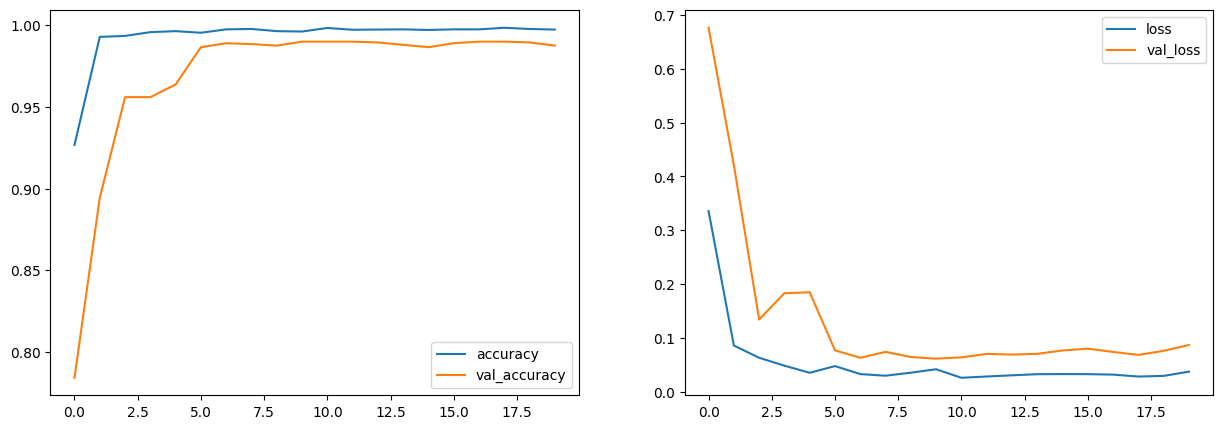

In [64]:
# See Model Performance in GRaph

metrics_2 = pd.DataFrame(model_lstm_3_hist.history)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

metrics_2[['accuracy', 'val_accuracy']].plot(ax=ax1)
metrics_2[['loss','val_loss']].plot(ax=ax2)

In [65]:
#Classification report

y_pred_lstm = model_lstm_3.predict(X_test)
y_pred_lstm = np.where(y_pred_lstm >= 0.5, 1, 0)

print(classification_report(y_test, y_pred_lstm))

65/65 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1600
           1       0.99      0.95      0.97       463

    accuracy                           0.99      2063
   macro avg       0.99      0.97      0.98      2063
weighted avg       0.99      0.99      0.99      2063



`Evaluation`

From LTSM graph plot of learning we can say that this model's accuracy spikes  sponateuously after 2 epoch, this means that this model learns so quickly up until it reaches ``more than 0.98 Accuracy``. But this sudden spike in accuracy ccould also indicates that maybe our sample is too small for our complex model 

Comapring the accuracy from train data to val data, it indicates that the model is only slightly overfit becuase there's a gap in between (0.01 points to be precise). 

Nevertheless, this model has no indication of gradient explotding, that a good indicators. AND this model has better performance than our base model ANN.

## Transfer Learning

### NNLM Model

Trial using transfer learning with NNLM Model (Embedding) by Google 

url = https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2 

Note that this model is enriched with embeded token trained on English Google News with 200 billion corpus.

This model also posses 3 Hidden Layers and 128 Embedding layers.

The writer of this notebook did not put any modification to this model because this model won't be used as deployment model. It's just as reference of how transfer learning performance looks like.

In [43]:
seed = 77
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# importing the embedding layer for transfer learning
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-id-dim128-with-normalization/2", input_shape=[], dtype=tf.string)

model_trf = keras.Sequential()
model_trf.add(hub_layer)
model_trf.add(keras.layers.Dense(16, activation='relu'))
model_trf.add(keras.layers.Dense(1, activation='sigmoid'))

model_trf.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 58)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 58, 128)           1603072   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,605,153
Trainable params: 1,605,153
Non-

In [44]:
model_trf_hist = model_trf.fit(X_train,
                         y_train,
                         epochs=20,
                         validation_data=(X_test, y_test))

Epoch 1/20
258/258 [==============================] - 1s 2ms/step - loss: 0.4505 - accuracy: 0.8319 - val_loss: 0.2718 - val_accuracy: 0.9258
Epoch 2/20
258/258 [==============================] - 0s 2ms/step - loss: 0.2024 - accuracy: 0.9463 - val_loss: 0.1494 - val_accuracy: 0.9612
Epoch 3/20
258/258 [==============================] - 0s 2ms/step - loss: 0.1366 - accuracy: 0.9629 - val_loss: 0.1193 - val_accuracy: 0.9714
Epoch 4/20
258/258 [==============================] - 0s 2ms/step - loss: 0.1126 - accuracy: 0.9686 - val_loss: 0.1035 - val_accuracy: 0.9729
Epoch 5/20
258/258 [==============================] - 0s 2ms/step - loss: 0.1012 - accuracy: 0.9720 - val_loss: 0.0969 - val_accuracy: 0.9753
Epoch 6/20
258/258 [==============================] - 0s 2ms/step - loss: 0.0945 - accuracy: 0.9731 - val_loss: 0.0933 - val_accuracy: 0.9743
Epoch 7/20
258/258 [==============================] - 0s 2ms/step - loss: 0.0897 - accuracy: 0.9731 - val_loss: 0.0925 - val_accuracy: 0.9743
Epoch 

<AxesSubplot: >

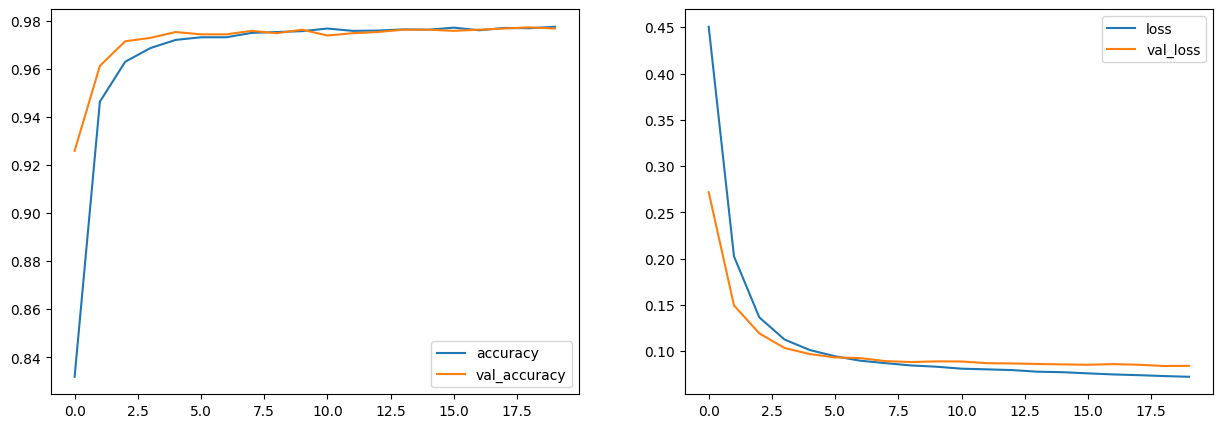

In [45]:
# see performance

metrics_trf = pd.DataFrame(model_trf_hist.history)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

metrics_trf[['accuracy', 'val_accuracy']].plot(ax=ax1)
metrics_trf[['loss','val_loss']].plot(ax=ax2)

As we expected from the transfer learning model, The accuracy and loss both in train and validation data reached an excelence performance. A very smooth graph with almost identical/parallel lines indicates that the model is very robust for this data.

This model is the epitome of GOOD FIT.

Achieving great accuracy of more than `0.97` from validation data and loss of `0.08` from validation data.

This NNLM model is widely and usually used to predict what words come next in a sentence.

In [66]:
#Classification report

y_pred_trf = model_trf.predict(X_test)
y_pred_trf = np.where(y_pred_trf >= 0.5, 1, 0)

print(classification_report(y_test, y_pred_trf))

65/65 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1600
           1       0.96      0.93      0.95       463

    accuracy                           0.98      2063
   macro avg       0.97      0.96      0.97      2063
weighted avg       0.98      0.98      0.98      2063



## Saving Model

In [94]:
# freeze model LSTM
model_lstm_3.trainable = False
model_lstm_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 58)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 58, 128)           1603072   
                                                                 
 lstm (LSTM)                 (None, 58, 32)            20608     
                                                                 
 dropout (Dropout)           (None, 58, 32)            0         
                                                                 
 batch_normalization (BatchN  (None, 58, 32)           128       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 58, 64)            2

In [93]:
# saving model LSTM
model_lstm_3.save('FINAL_LSTM.tf')

INFO:tensorflow:Assets written to: FINAL_LSTM.tf\assets


INFO:tensorflow:Assets written to: FINAL_LSTM.tf\assets


## Conclussion & Reccomendation

From the analysis above, following Information can be retreived:

1. EDA :
    - The data gathered is highly containing tweet with label not depressed with percentage 78%. This matched the real world case logically.

    - Tweets that has negative tendency or depressing tendency has 'depression' as the most used words and also emotion words such as 'crying', 'anxiety' as aslo action such as 'suicide' etc.

    - On tweet labeled as depression, the words distributions are more uniform than the data labled as non-depression. This is interesting as we know that one word alone are not sufficient to indentify depression case. So generally to identify depression we need more context and advanced model to classify it.

    - An obvious information can be seen that the words 'love', 'good' , 'thank' is significantly appeared more in non depressing tweet.
.
2. Modelling :

    - In base model ANN, we got great accuracy of 98%. But the problem is that the model is overfitting and the loss is getting bigger in each iteration (epoch). Plus the very steady line indicating that the model learn too fast.

    - In GRU model, we are exposed to poor performance due to gradient exploding problem. The model is not learning and performing very well.

    - In LSTM model, we can see a similarity between the model performance. But the thing is that in ANN Base model, we find bigger gap in the loss metrics indicating more overfitiing of te model and also less accuracy. So we choose LSTM Model to be deployed because it has better performance in loss metric and also slightly better accuracy.


3. About LSTM :

    - ``LSTM`` Model is considered robust to gradient vanishing problem and also robust to noisy/unimportant inputs. This is because LSTM 'forgot' the unimportant input and only focus on the important ones.

    - `LSTM` model is very good for data that has long-term depedencies, where knowledge from previous time is relevant to the future. It is very good to be applied in NLP case because sentences has context and this context (replationship between words) is very important to understand the meaning of the text or documents

    

As for the Reccomendation :

- For the model, it needs more exploration and tuning and better architcture, especially to handle unbalanced dataset. Some technique like regularization and applying class weight might help. Another alternative is using Undersampling or Oversampling method to make the data balanced.